# Feature extraction

In this notebook we use the fine-tuned DeepLabV3 segmentation model [1] to segment the ears and crop the ears. Extracted ears are than encoded using local binary patterns [3] and resnet50 features [2].

In more detail we try out the following two methods:

1. feature vector is a histogram of extracted Local Binary Patterns (LBPs)
2. feature vector is a histogram of extracted Local Binary Patterns (LBPs) concatenated with ResNet50 (trained on ImageNet) feature vector

**References**

[1] https://github.com/Matjaz12/Ear-Recognition-Pipeline/blob/main/segmentation.ipynb

[2] https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html

[3] https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html


## Setup

Import dependencies, mount google drive and unzip data.

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from skimage import io, transform
import PIL
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, utils
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = "IBB5"
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
DATA_PATH = '/content/drive/My Drive/{}'.format(FOLDERNAME)
print(DATA_PATH)
sys.path.append(DATA_PATH)

ROOT_PATH = "."

Mounted at /content/drive
/content/drive/My Drive/IBB5


In [ ]:
!unzip "/content/drive/My Drive/IBB5/data.zip" 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ROOT_PATH = "/kaggle/input/eardataset/"


## ResNet50

Load ResNet50 pretrained on ImageNet. We'll use the ResNet50 model for inference (i.e we'll pass a cropped ear through the network and use its associated last fully connected layer as a feature vector). 

In [108]:
from torchvision.models import resnet50, ResNet50_Weights
resnet50_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

In [109]:
resnet50_feature_extractor = torch.nn.Sequential(*list(resnet50_model.children())[:-1])

## Local Binary Patterns

In [157]:
import numpy as np
import numpy.typing as npt
from skimage import feature
from tqdm import tqdm
from sympy import divisors


def compute_concatenated_histogram(image, tile_size, num_bins):
    """
    Function computes a concatenated histogram, by spliting the image
    into tiles of size `tile_size` and computing a local histogram on each tile.
    Histograms are normalized and concatenated together.

    :param image: Input image
    :param tile_size: Size of each tile (Width, Height)
    :param num_bins: Number of bins used in computation of local histogram.
    :return: Concatenated histogram.
    """

    height, width = image.shape
    tile_height, tile_width = tile_size
    fv = []

    # Split image into tiles of size (tile_height x tile_width)
    tiled_image = image.reshape(height // tile_height,
                                tile_height,
                                width // tile_width,
                                tile_width)

    tiled_image = tiled_image.swapaxes(1, 2)
    tiled_image = tiled_image.reshape(tiled_image.shape[0] * tiled_image.shape[1], tile_height, tile_width)

    # Compute histogram for each tile and concatenate them
    for tile in tiled_image:
        from scipy.sparse import csr_matrix
        tile_hist, _ = np.histogram(tile, density=True, bins=num_bins, range=(0, num_bins))
        fv.extend(tile_hist)

    # Normalize the concatenated histogram
    fv = np.array(fv)
    # fv = fv / np.sum(fv)

    return fv


class ScikitLBP:
    def __init__(self, num_points: int = 8, radius: int = 1, to_hist: bool = True, method: str = "default"):
        self.num_points = num_points
        self.radius = radius
        self.to_hist = to_hist
        self.method = method

    def describe(self, images: npt.NDArray, *args, **kwargs) -> npt.NDArray:
        """
        Function computes a feature vector for each image.

        :param images: A set of images.
        :return: A set of feature vectors.
        """

        fvs = []

        if self.to_hist:
            image_size_divisors = list(divisors(images[0].shape[0], generator=True))[1: -1]
            tile_width = kwargs.get("tile_width", image_size_divisors[len(image_size_divisors) // 2])
            # print(f"tile width: {tile_width}")
            # print(f"number of tiles: {(images[0].shape[0] / tile_width) ** 2}")

        # Extract features for each image
        for image in images:
            image_lbp = feature.local_binary_pattern(image, self.num_points, self.radius, method=self.method)

            # Compute feature vector
            if self.to_hist:
                num_bins = int(image_lbp.max()) + 1
                fv = compute_concatenated_histogram(image_lbp, tile_size=(tile_width, tile_width),
                                                    num_bins=num_bins)
            else:
                fv = image_lbp.flatten()

            # Store feature vector
            fvs.append(fv)

        fvs = np.array(fvs)
        return fvs

    def __str__(self):
        return "ScikitLBP"

## Load Finetuned DeepLabV3 model

In [6]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import torchvision

def get_model(out_channels=1, train_mode=False, pretrained=True):
    """
    DeepLabv3 class with a custom head.
    """
    # Load the pretrained model
    model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=pretrained)

    # Replace the classifier module with a new head
    model.classifier = DeepLabHead(2048, out_channels)

    # Set model in appropriate mode
    model.train() if train_mode else model.eval()

    return model

In [7]:
!cp -r "/content/drive/My Drive/IBB5/results/DeepLabV3_v1" "./"

In [28]:
!cp -r "/content/drive/My Drive/IBB5/results/annotations_train.csv" "./"

In [ ]:
MODELS_DIR = "./DeepLabV3_v1"
deeplabv3_model = get_model(out_channels=1, train_mode=False, pretrained=True)
deeplabv3_model.load_state_dict(torch.load(MODELS_DIR))

**Copy over hyper-parameters**

In [14]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_WORKERS = 0 # 2
IMAGE_HEIGHT = 300 
IMAGE_WIDTH = 300 
PIN_MEMORY = True

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [169]:
class EarClassificationDataset(Dataset):
    def __init__(
        self, annotations_file, image_dir="./images", transform=None
    ):
        super().__init__()
        self.annotations = pd.read_csv(annotations_file, delimiter="\t", dtype="str")
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Fetch image
        folder_name, file_name = np.array(self.annotations.iloc[idx, :2])
        image_name = os.path.join(self.image_dir, f"{folder_name}/{file_name}.png")
        label = f"{folder_name}/{file_name}"

        # Read the image and covert to numpy array
        image = np.array(PIL.Image.open(image_name))

        if self.transform:
            augmentation = self.transform(image=image)
            image = augmentation["image"]

        return image, label

In [170]:
from albumentations.pytorch import ToTensorV2
import albumentations

preprocess_transform = albumentations.Compose([
    albumentations.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT),
    albumentations.Normalize(mean=mean, std=std, max_pixel_value=255.0),
    ToTensorV2(transpose_mask=True)
])

train_dataset = EarClassificationDataset(annotations_file="./annotations_train.csv",
                                image_dir=f"{ROOT_PATH}/images",
                                transform=preprocess_transform)

image, label = train_dataset[0]
image.shape, label

(torch.Size([3, 300, 300]), '001/02')

In [115]:
def crop_image(image, pred_mask):
    image = image.to("cpu").detach()
    pred_mask = pred_mask.to("cpu").detach()

    image = image[0].numpy()
    image = image.transpose((1, 2, 0))

    pred_mask = pred_mask[0].numpy()
    pred_mask = pred_mask.squeeze(axis=0)

    # Compute masked image
    pred_mask = np.stack((pred_mask, ) * 3, axis=-1)
    masked_image = image * pred_mask

    # Compute cropped image
    nonzero_rows, nonzero_cols = np.nonzero(masked_image.mean(axis=2))
    seg_y_start, seg_y_end = nonzero_rows.min(), nonzero_rows.max() + 1
    seg_x_start, seg_x_end = nonzero_cols.min(), nonzero_cols.max() + 1

    cropped_image = masked_image[seg_y_start:seg_y_end, seg_x_start:seg_x_end, :]

    return cropped_image


def plot_image_and_cropped_ear(image, pred_mask, cropped_image):
    image = image[0].to("cpu").detach()
    pred_mask = pred_mask[0].to("cpu").detach()

    if torch.is_tensor(image):
        image = image.numpy()
        image = image.transpose((1, 2, 0))

    if torch.is_tensor(pred_mask):
        pred_mask = pred_mask.numpy()
        pred_mask = pred_mask.squeeze(axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image)
    ax1.imshow(pred_mask, alpha=0.6 * (pred_mask > 0))
    ax2.imshow(cropped_image)
    plt.show()


def plot_predictions(images, masks, pred_masks, n_samples=3):
    images = images.to("cpu").detach()
    masks = masks.to("cpu").detach()
    pred_masks = pred_masks.to("cpu").detach()

    for idx, (image, mask, pred_mask) in enumerate(zip(images, masks, pred_masks)):
        if idx == n_samples:
            break

        if torch.is_tensor(image):
            image = image.numpy()
            image = image.transpose((1, 2, 0))

        if torch.is_tensor(mask):
            mask = mask.numpy()
            mask = mask.squeeze(axis=0)

        if torch.is_tensor(pred_mask):
            pred_mask = pred_mask.numpy()
            pred_mask = pred_mask.squeeze(axis=0)

        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        # plt.imshow(mask, alpha=0.6 * (mask > 0))
        plt.imshow(pred_mask, alpha=0.6 * (pred_mask > 0))
        plt.show()
        
        
def de_normalize(images, mean, std):
    if isinstance(mean, list):
        mean = torch.tensor(mean).reshape((3, 1, 1)).to(DEVICE)
        
    if isinstance(std, list):
        std = torch.tensor(std).reshape((3, 1, 1)).to(DEVICE)
    
    images = images.to(DEVICE)
    images = images * std + mean
    
    return images


def normalize(images, mean, std):
    if isinstance(mean, list):
        mean = torch.tensor(mean).reshape((3, 1, 1)).to(DEVICE)
        
    if isinstance(std, list):
        std = torch.tensor(std).reshape((3, 1, 1)).to(DEVICE)
    
    images = images.to(DEVICE)
    images = (images - mean) / std
    
    return images

## Extract Features and save Feature maps


Iterate over training images, extract features and save them to the database.

In [113]:
OUT_IMAGE_HEIGHT, OUT_IMAGE_WIDTH = IMAGE_HEIGHT, IMAGE_WIDTH

def segment_ear(model, image, threshold):
    image = image.unsqueeze(dim=0).to(DEVICE)
    model = model.to(DEVICE)

    # Predict a segmentation mask and apply threshold
    pred_mask = torch.sigmoid(model(image)["out"])        
    pred_mask[pred_mask >= threshold] = 1.0
    pred_mask[pred_mask < threshold] = 0.0

    # Crop image using predicted seg. mask & rescale the image
    cropped_image = crop_image(de_normalize(image, mean, std), pred_mask)
    cropped_image = Image.fromarray(np.uint8(cropped_image * 255)).resize((IMAGE_HEIGHT, IMAGE_WIDTH))

    return cropped_image


def resnet_50_features(feature_extractor, image):
    # Convert image to tensor
    image_c = np.array(image).transpose((2, 0, 1))
    image_c = torch.from_numpy(image_c)

    # Normalize image
    image_c = (image_c / 255.0).unsqueeze(dim=0)
    image_c = normalize(image_c, mean, std)

    # Move data and model on the device
    feature_extractor = feature_extractor.to(DEVICE)
    image_c = image_c.to(DEVICE)

    feature_vect = feature_extractor(image_c).flatten()

    return feature_vect

TILE_WIDTH: 6


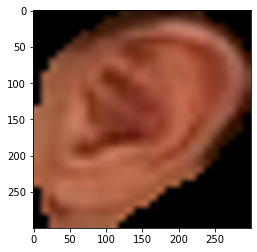

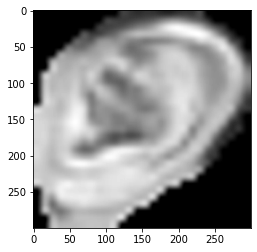

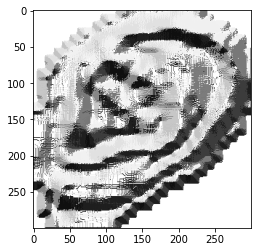

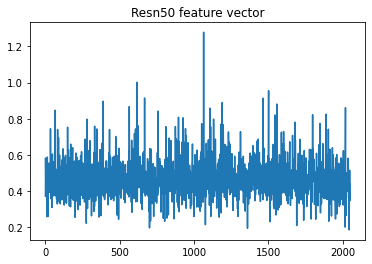

In [128]:
from PIL import Image

THRESHOLD = 0.25

lbp_descriptor = ScikitLBP(num_points=8, radius=1, to_hist=False, method="default")
tile_sizes = list(divisors(image[0].shape[0], generator=True))[1: -1]
TILE_WIDTH = tile_sizes[3]

print(f"TILE_WIDTH: {TILE_WIDTH}")


with torch.no_grad():
    for idx, (image, label) in enumerate(train_dataset):

        # Segment ear from the image
        cropped_image = segment_ear(deeplabv3_model, image, THRESHOLD)
        plt.imshow(cropped_image)
        plt.show()

        # Convert to gray scale
        cropped_gray_image = np.array(cropped_image.convert("L"))
        plt.imshow(cropped_gray_image, cmap="gray")
        plt.show()

        # Extract local binary patterns
        feature_vect = lbp_descriptor.describe(cropped_gray_image[np.newaxis, :, :], tile_width=TILE_WIDTH)[0]
        feature_vect = feature_vect.reshape((cropped_gray_image.shape))

        plt.imshow(feature_vect, cmap="gray")
        plt.show()

        # ResNet50 (ImageNet) features
        feature_vector = resnet_50_features(resnet50_feature_extractor, cropped_image)
        plt.plot(feature_vector.cpu())
        plt.title("Resn50 feature vector")
        plt.show()

        break

**Save extracted Features**

In [162]:
LBP_FEATURES_DIR = "./lbp_features"
LBP_RESNET_FEATURES_DIR = "./lbp_resnet_features"

In [204]:
from PIL import Image
import pickle

THRESHOLD = 0.25

lbp_descriptor = ScikitLBP(num_points=8, radius=1, to_hist=True, method="default")
tile_sizes = list(divisors(image[0].shape[0], generator=True))[1: -1]
TILE_WIDTH = tile_sizes[6]

print(f"TILE_WIDTH: {TILE_WIDTH}")

with torch.no_grad():
    for idx, (image, label) in enumerate(train_dataset):
        # Segment ear from the image
        cropped_image = segment_ear(deeplabv3_model, image, THRESHOLD)

        # Convert to gray scale
        cropped_gray_image = np.array(cropped_image.convert("L"))

        # Extract local binary patterns
        lbp_fv = lbp_descriptor.describe(cropped_gray_image[np.newaxis, :, :], tile_width=TILE_WIDTH)[0]

        # ResNet50 (ImageNet) features
        resnet_fv = resnet_50_features(resnet50_feature_extractor, cropped_image).cpu()

        # Save LBP features
        if not os.path.exists(f"{LBP_FEATURES_DIR}/{label.split('/')[0]}"):
            os.makedirs(f"{LBP_FEATURES_DIR}/{label.split('/')[0]}")

        with open(f"{LBP_FEATURES_DIR}/{label}.pickle", "wb") as handle:
            pickle.dump(lbp_fv, handle)

        # Save LBP and ResNet50 features
        if not os.path.exists(f"{LBP_RESNET_FEATURES_DIR}/{label.split('/')[0]}"):
            os.makedirs(f"{LBP_RESNET_FEATURES_DIR}/{label.split('/')[0]}")

        with open(f"{LBP_RESNET_FEATURES_DIR}/{label}.pickle", "wb") as handle:
            fv = np.concatenate([lbp_fv, resnet_fv])
            pickle.dump(fv, handle)

        break

TILE_WIDTH: 10
